## 1. Load libraries and read the data

In [65]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

# For scaling the data
from sklearn.preprocessing import StandardScaler

# To perform K-means clustering
from sklearn.cluster import KMeans


#To perform hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [66]:
data_dict = pd.read_csv('data-dictionary+.csv')

In [67]:
data_dict

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 1000 live births
2,exports,Exports of goods and services per capita. Given as %age of the GDP per capita
3,health,Total health spending per capita. Given as %age of GDP per capita
4,imports,Imports of goods and services per capita. Given as %age of the GDP per capita
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of the Total GDP
7,life_expec,The average number of years a new born child would live if the current mortality patterns are to remain the same
8,total_fer,The number of children that would be born to each woman if the current age-fertility rates remain the same.
9,gdpp,The GDP per capita. Calculated as the Total GDP divided by the total population.


In [68]:
countries = pd.read_csv('Country-data.csv')

In [69]:
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [70]:
countries.shape

(167, 10)

Since the exports, healths and imports are given as percentage of GDPP. First we will convert them to their actual values respectively. This will help us to get the actual comparisons among the countries.


In [71]:
# features = ['exports', 'health', 'imports']
# for feature in features:
#     countries[feature] = countries[feature]*countries['gdpp']/100
countries[['exports', 'health', 'imports']]= \
                                countries[['exports', 'health', 'imports']].multiply(countries["gdpp"]/100, axis="index")


In [72]:
countries.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [73]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [74]:
#checking for duplicates
countries.duplicated(subset = ['country'], keep = False).sum()

0

There are no duplicated rows

In [75]:
# Checking for null values in the column
countries.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

There are no NULL values in the dataset

#### Checking for outliers and treating it

In [76]:
countries.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
90%,100.220000,17760.600000,3825.416000,15034.280000,41220.000000,16.640000,80.400000,5.322000,41840.000000
95%,116.000000,31385.100000,4966.701000,24241.560000,48290.000000,20.870000,81.400000,5.861000,48610.000000
99%,153.400000,64794.260000,8410.330400,55371.390000,84374.000000,41.478000,82.370000,6.563600,79088.000000


### Performing Univariate Ananlysis on all the features

In [77]:
features = countries.columns
features

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

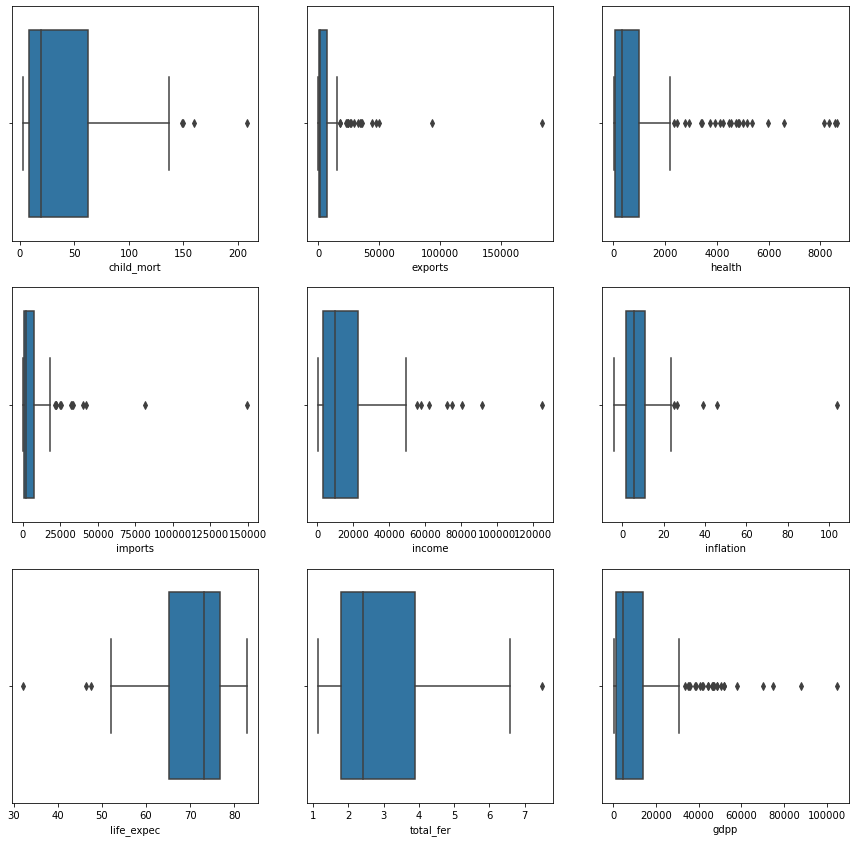

In [78]:
fig = plt.figure(figsize=(15,25))
for plot, feature in enumerate(features[1:]):
    fig.add_subplot(5,3,plot+1)
    sns.boxplot(x=countries[feature], data=countries)
                 

From the above plots, we can conculde the following:
- There are outliers in each features.
- Most of the outliers are in health, exports and gdpp
- There are only 167 rows(countries), so removing these outliers will delete the crucial information from the datesets.
- Specially the countries which have exceptionally high child mortalities(outliers), will be missed, which actually need the aid from the NGO. For example, in case of Child Mortality rate, country with value `208` is an outlierm, however, the coutry itself could in dire need of aid.
- So I chose to treat the outliers only in the `gdpp` column. The coutries with high `gdpp` would not require an aid. So I will remove those from the dataset.

In [79]:
#Caluclating the quantile1 and quantile3 for gdpp and removing the upper outliers
Q1 = countries.gdpp.quantile(0.05)
Q3 = countries.gdpp.quantile(0.95)

countries[(countries.gdpp > Q3)]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
7,Australia,4.8,10276.2,4530.87,10847.1,41400,1.160,82.0,1.93,51900
44,Denmark,4.1,29290.0,6612.00,25288.0,44000,3.220,79.5,1.87,58000
73,Ireland,4.2,50161.0,4475.53,42125.5,45700,-3.220,80.4,2.05,48700
91,Luxembourg,2.8,183750.0,8158.50,149100.0,91700,3.620,81.3,1.63,105000
110,Netherlands,4.5,36216.0,5985.70,31990.8,45500,0.848,80.7,1.79,50300
114,Norway,3.2,34856.6,8323.44,25023.0,62300,5.950,81.0,1.95,87800
123,Qatar,9.0,43796.9,1272.43,16731.4,125000,6.980,79.5,2.07,70300
144,Sweden,3.0,24070.2,5017.23,21204.7,42900,0.991,81.5,1.98,52100
145,Switzerland,4.5,47744.0,8579.00,39761.8,55500,0.317,82.2,1.52,74600


###### In the above table we can see, that Qatar is having a high child mortality rate of 9.0, but its other features like gdpp, total_fertility rate, income etc are in the higher range. So it would not be first in the list of needy countries.

After removing the outlier

In [80]:
countries = countries[(countries.gdpp <= Q3)]

In [81]:
countries.shape

(158, 10)

In [82]:
countries.head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


#### Visulaizing the data using Pair Plot

<Figure size 1440x2520 with 0 Axes>

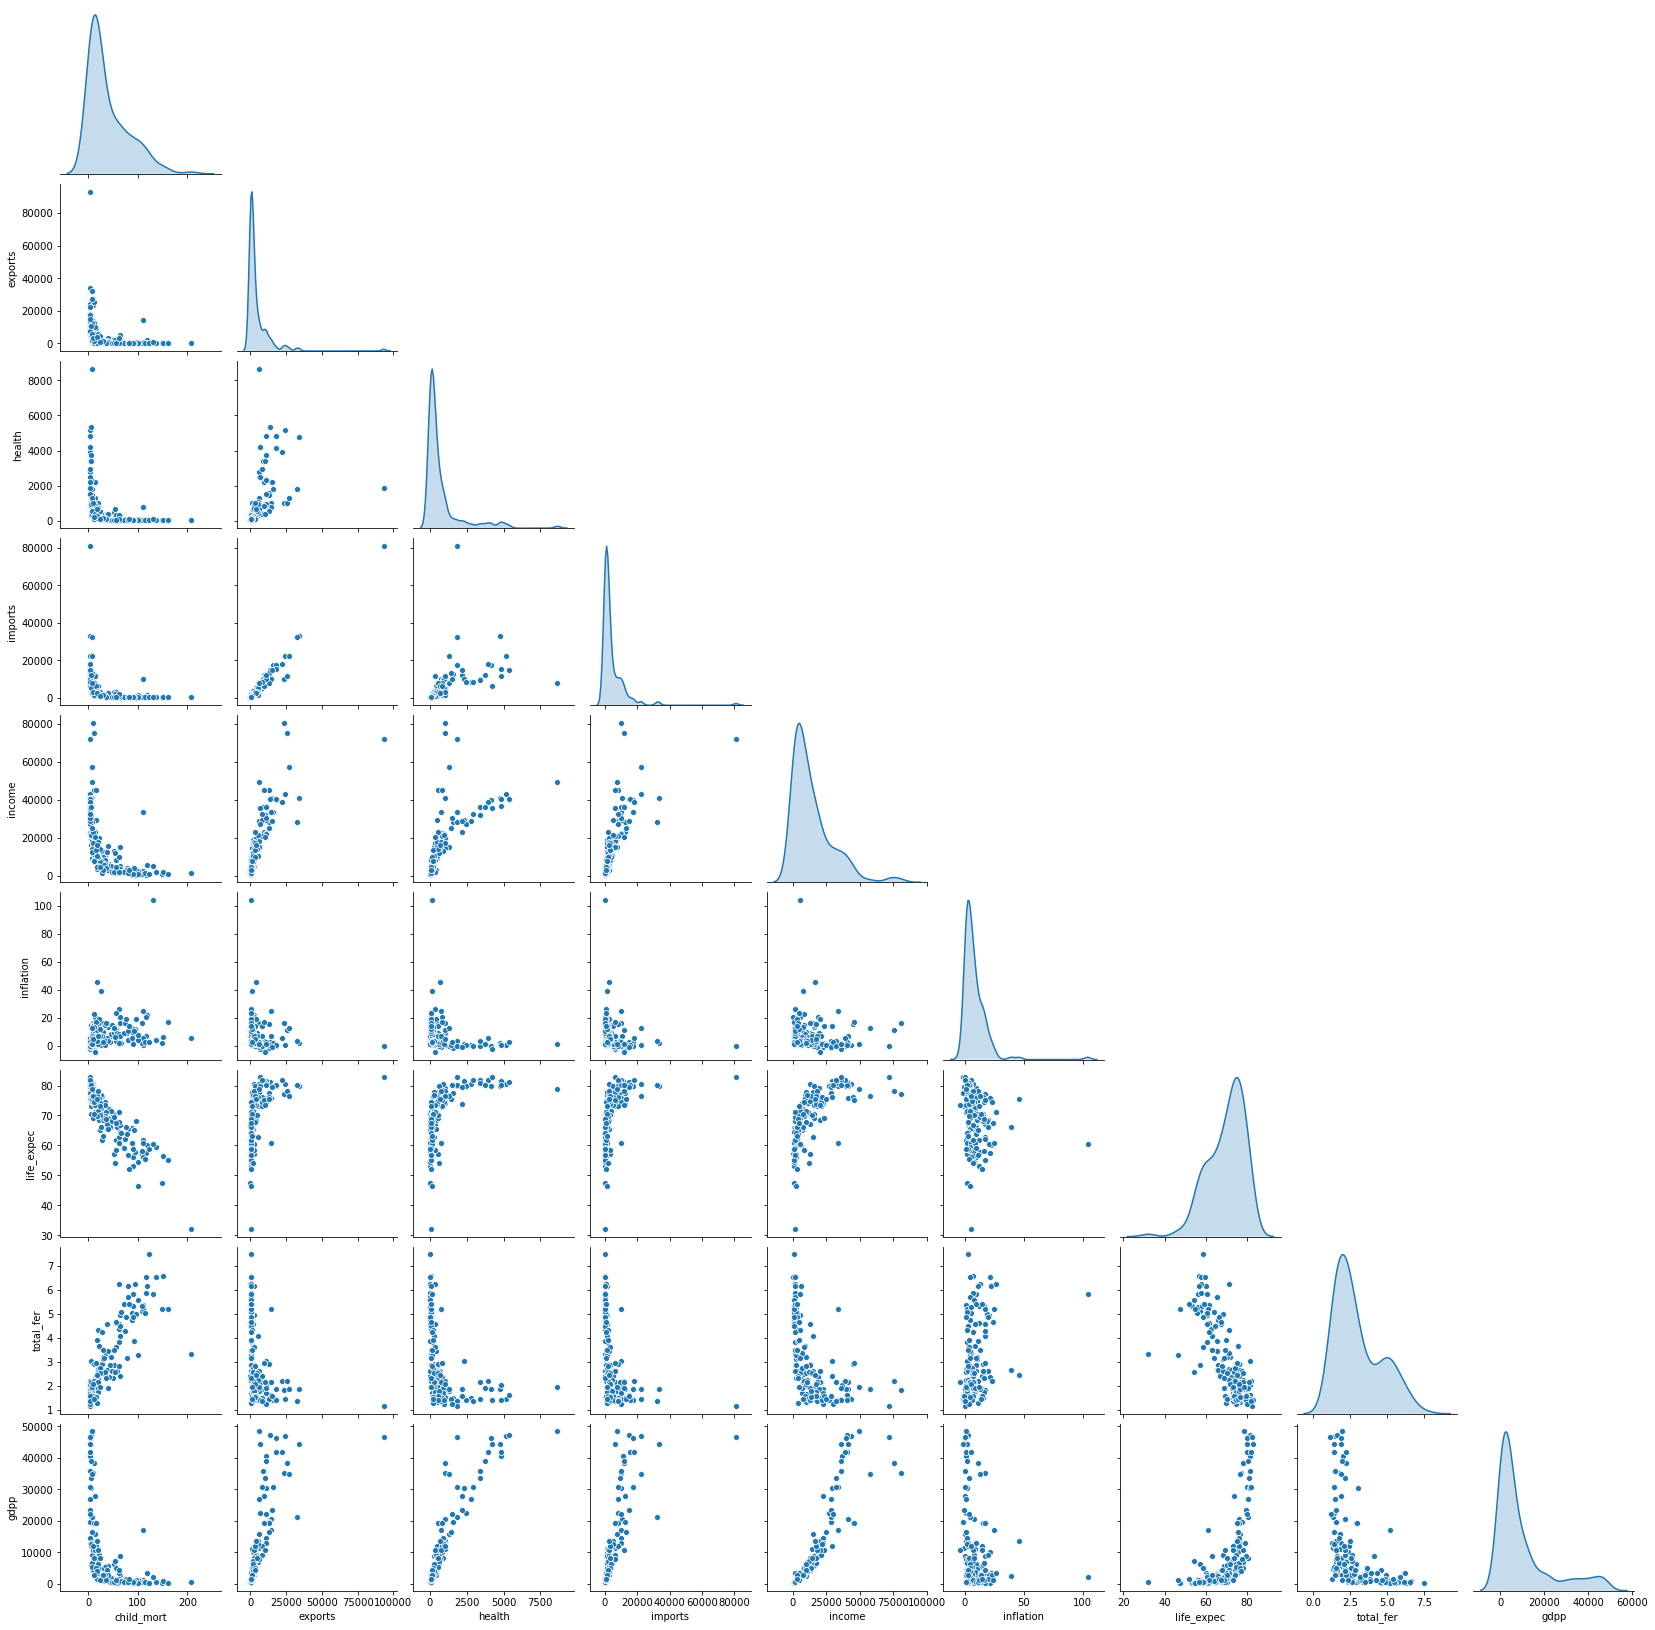

In [124]:
fig = plt.figure(figsize=(20,35))
sns.pairplot(countries,diag_kind='kde',corner=True)

From the above plots we can conclude the following about gddp
- It is highly and positively correlated with life expectancy and income
- It is inversely correlated with child_mortality, total fertility and inflation
- health, imports and exports are also positively correlated with gddp
- Also there is linear realtionship between gdpp vs income,imports vs exports, total_fer  vs child_mort

### Top 10 under developed coutries based on the data visulaization 

###### Top 10 coutries with highest mortality rate

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

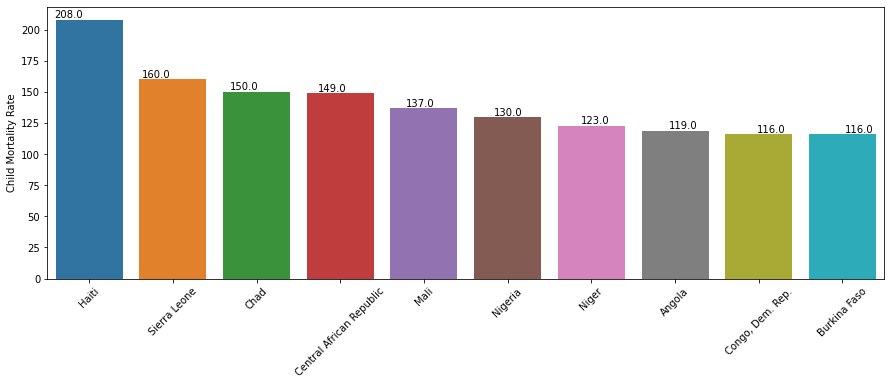

In [84]:
plt.figure(figsize = (15,5))
child_mort_top10 = countries[['country','child_mort']].sort_values('child_mort', ascending = False).head(10)
ax=sns.barplot(x='country', y='child_mort', data= child_mort_top10)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.05 , p.get_height() * 1.01))
ax.set(xlabel = '', ylabel= 'Child Mortality Rate')
plt.xticks(rotation=45)

###### Top 10 countries with the `lowest` spending on health

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

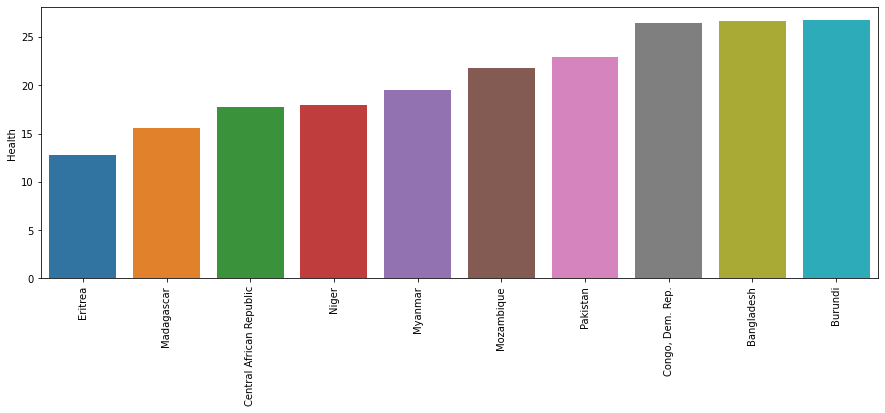

In [85]:
plt.figure(figsize = (15,5))
health = countries[['country','health']].sort_values('health', ascending = True).head(10)
ax = sns.barplot(x='country', y='health', data= health)
ax.set(xlabel = '', ylabel= 'Health')
plt.xticks(rotation=90)

###### Top 10 countries with lowest per capita income.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

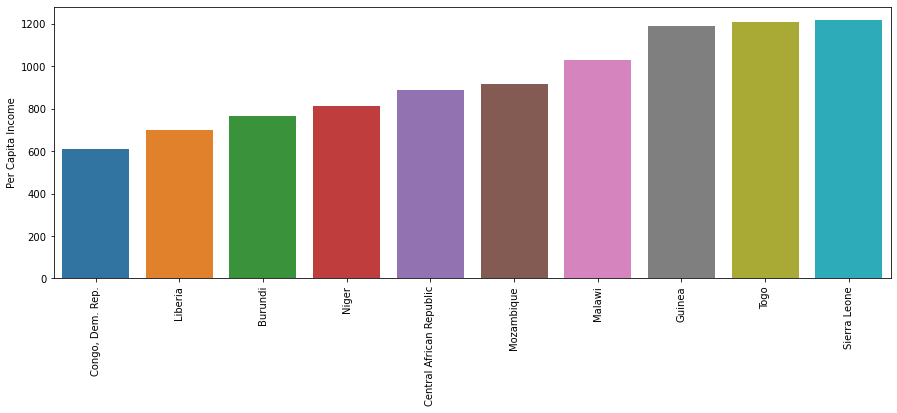

In [86]:
plt.figure(figsize = (15,5))
income_lowets_10 = countries[['country','income']].sort_values('income', ascending = True).head(10)
axes = sns.barplot(x='country', y='income', data= income_lowets_10)
axes.set(xlabel = '', ylabel= 'Per Capita Income')
plt.xticks(rotation=90)

###### Top 10 Countries with the highest Inflation rate.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

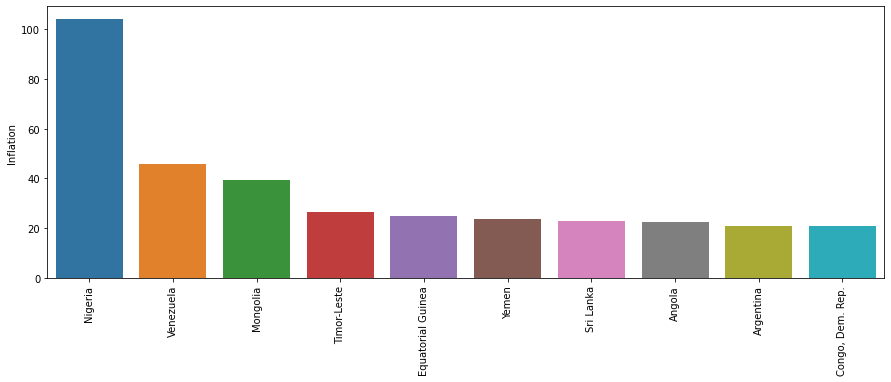

In [87]:
plt.figure(figsize = (15,5))
high_inflation = countries[['country','inflation']].sort_values('inflation', ascending = False).head(10)
ax = sns.barplot(x='country', y='inflation', data= high_inflation)
ax.set(xlabel = '', ylabel= 'Inflation')
plt.xticks(rotation=90)


From the above plot we can see that is Nigeria is clearly standing out having the highest infaltion.

#### From the above visulizations we get a good idea about the under developed countries which might be in need of the NGOs aid.


#### Checking if the datset is fit for applying clustering on it

In [88]:
#Find the Hopkins statistic score
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [89]:
hopkins(countries.drop('country', axis = 1))

0.9717598121907283

### We have got the Hopkins score close to 1 which tends to indicate the data is highly clustered

### Preparing the dataset for clustering

#### Scaling the dataset

In [90]:
features = countries.columns
standard_scaler = StandardScaler()
countries_scaled= standard_scaler.fit_transform(countries.drop('country', axis=1))
countries_scaled

array([[ 1.2348468 , -0.51008966, -0.56360764, ..., -1.57290118,
         1.83898931, -0.73837646],
       [-0.58270965, -0.39606338, -0.39146172, ...,  0.7236459 ,
        -0.88967589, -0.45936668],
       [-0.3184725 , -0.33669732, -0.45386166, ...,  0.74649712,
        -0.07827425, -0.4301799 ],
       ...,
       [-0.41725274, -0.4171968 , -0.5272808 , ...,  0.35802647,
        -0.69336904, -0.6786619 ],
       [ 0.39768425, -0.4747592 , -0.54384653, ..., -0.28180754,
         1.08647972, -0.6786619 ],
       [ 1.05951187, -0.45935901, -0.53003083, ..., -2.05277669,
         1.56415972, -0.66682942]])

In [91]:
country_norm = pd.DataFrame(countries_scaled)
country_norm.columns = features[1:]
country_norm.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.234847,-0.510090,-0.563608,-0.530152,-0.856955,0.124994,-1.572901,1.838989,-0.738376
1,-0.582710,-0.396063,-0.391462,-0.321693,-0.308713,-0.336520,0.723646,-0.889676,-0.459367
2,-0.318473,-0.336697,-0.453862,-0.392076,-0.113006,0.745941,0.746497,-0.078274,-0.430180
3,1.946065,-0.285794,-0.518900,-0.378423,-0.574267,1.333323,-1.127302,2.061470,-0.503541
4,-0.738289,0.064875,-0.035126,0.301255,0.295540,-0.620888,0.780774,-0.575585,0.180376


#### Finding the  Silhouette score

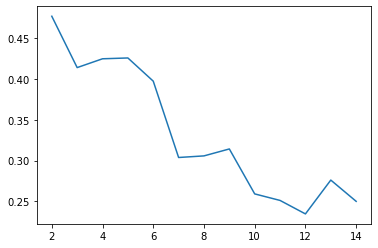

In [92]:
from sklearn.metrics import silhouette_score
ss = []
for k in range(2, 15):
    kmean = KMeans(n_clusters = k).fit(country_norm)
    ss.append([k, silhouette_score(country_norm, kmean.labels_)])
temp = pd.DataFrame(ss)    
plt.plot(temp[0], temp[1])

#### Elbow score

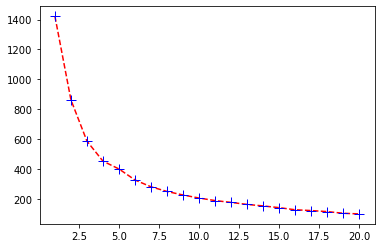

In [93]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(country_norm)
    ssd.append(model_clus.inertia_)

    
fig, ax = plt.subplots()
ax.plot(range(1,21),ssd, marker = '+',color = 'red' , ls = '--', markeredgecolor = 'blue', markersize = '10')

###### By looking silhouette plot, we see the highest peak is at k = 4 and in sum of squared distances plot , we see that the elbow is in the range of 3 to 5 , so let us take k as 4.

### Performing K-Means Clustering on the scaled dataset


In [94]:
kmeans_clus4 = KMeans(n_clusters=4, max_iter=50, random_state= 50)
kmeans_clus4.fit(country_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [95]:
kmeans_clus4.labels_

array([1, 2, 2, 1, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1, 2,
       0, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 0, 0, 2,
       2, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 2, 1, 1, 2, 1, 2,
       0, 2, 2, 2, 1, 0, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1, 1, 2, 2,
       2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 1, 1, 0,
       1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 1, 2, 2, 1, 3, 0, 0, 1, 1, 0,
       0, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 0, 0, 2, 2, 2,
       2, 2, 1, 1])

In [96]:
#Finding the labels and converting it to series so that it can be appended to the `original countries` easily.
labels_kmeans = pd.Series(kmeans_clus4.labels_, index=countries.index)

In [97]:
#Adding the labels to countries dataset
countries_kmeans = countries.copy()
countries_kmeans['Labels'] = labels_kmeans
countries_kmeans.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,1
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,1
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,2


### Checking the number of countries assigned to each clusters

In [98]:
countries_kmeans['Labels'].value_counts()

2    80
1    48
0    29
3     1
Name: Labels, dtype: int64

## Profiling the clusters based on  - [gdpp, child_mort and income] 

#### Bivariate analysis of clustered countries 

[Text(0, 0.5, 'Child Mortality Rate'), Text(0.5, 0, 'GDPP')]

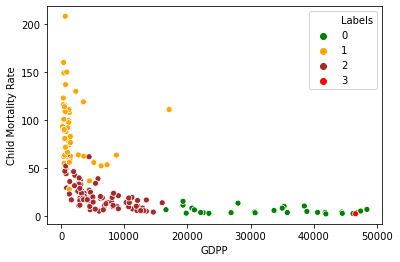

In [99]:
axes = sns.scatterplot(x='gdpp',y='child_mort',hue='Labels',legend='full',data=countries_kmeans, palette=['green','orange','brown','red'])
axes.set(xlabel = 'GDPP', ylabel= 'Child Mortality Rate')

[Text(0, 0.5, 'Income'), Text(0.5, 0, 'GDPP')]

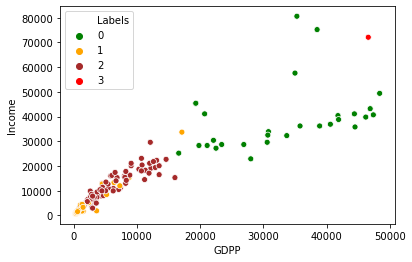

In [100]:
axes = sns.scatterplot(x='gdpp',y='income',hue='Labels',legend='full',data=countries_kmeans, palette=['green','orange','brown','red'])
axes.set(xlabel = 'GDPP', ylabel= 'Income')

[Text(0, 0.5, 'Income'), Text(0.5, 0, 'Child Mortality Rate')]

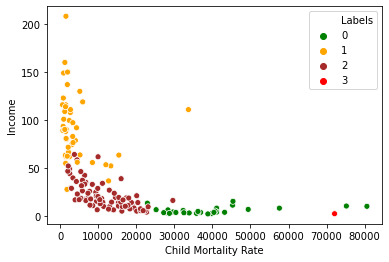

In [101]:
axes= sns.scatterplot(x='income',y='child_mort',hue='Labels',legend='full',data=countries_kmeans, palette=['green','orange','brown','red'])
axes.set(xlabel = 'Child Mortality Rate', ylabel= 'Income')

### From the above 3 scatterplots we can deduce the following insights about the clusters, specially about the clster labeled 1.

- In the gdpp vs child_mort plot, the child_mort is high when gdpp is low.
- In the gdpp vs income, when the gdpp is average the income is average.
- In the income vs child_mort, when income is high the child mortality is low and vice versa.

#### Taking the means and analyzing the clusters further

In [102]:
child_mort_mean =pd.DataFrame(countries_kmeans.groupby(["Labels"]).child_mort.mean())
exports_mean=pd.DataFrame(countries_kmeans.groupby(["Labels"]).exports.mean())
health_mean =pd.DataFrame(countries_kmeans.groupby(["Labels"]).health.mean())
imports_mean =pd.DataFrame(countries_kmeans.groupby(["Labels"]).imports.mean())
income_mean =pd.DataFrame(countries_kmeans.groupby(["Labels"]).income.mean())
inflat_mean =pd.DataFrame(countries_kmeans.groupby(["Labels"]).inflation.mean())
life_expec_mean =pd.DataFrame(countries_kmeans.groupby(["Labels"]).life_expec.mean())
total_fer_mean =pd.DataFrame(countries_kmeans.groupby(["Labels"]).total_fer.mean())
gdpp_mean =pd.DataFrame(countries_kmeans.groupby(["Labels"]).gdpp.mean())

In [103]:
cluster_analysis_df = pd.concat([pd.Series([0,1,2,3]),child_mort_mean,exports_mean,health_mean,imports_mean,income_mean,inflat_mean,life_expec_mean,
                                 total_fer_mean,gdpp_mean], axis=1)

In [104]:
cluster_analysis_df.columns = ["Labels","child_mort_mean","exports_mean","health_mean","imports_mean","income_mean","inflation_mean","life_expec_mean","total_fer_mean","gdpp_mean"]
cluster_analysis_df

,Labels,child_mort_mean,exports_mean,health_mean,imports_mean,income_mean,inflation_mean,life_expec_mean,total_fer_mean,gdpp_mean
0,0,6.148276,15076.862069,2941.186552,13582.134483,39024.137931,3.750069,79.268966,1.823448,32796.551724
1,1,91.610417,879.063521,114.821765,827.028771,3897.354167,11.911146,59.239583,4.992083,1909.208333
2,2,22.157500,2580.729982,385.856630,2793.990264,11478.625000,7.490737,72.871250,2.273375,5962.150000
3,3,2.800000,93200.000000,1845.360000,81084.000000,72100.000000,-0.046000,82.700000,1.150000,46600.000000


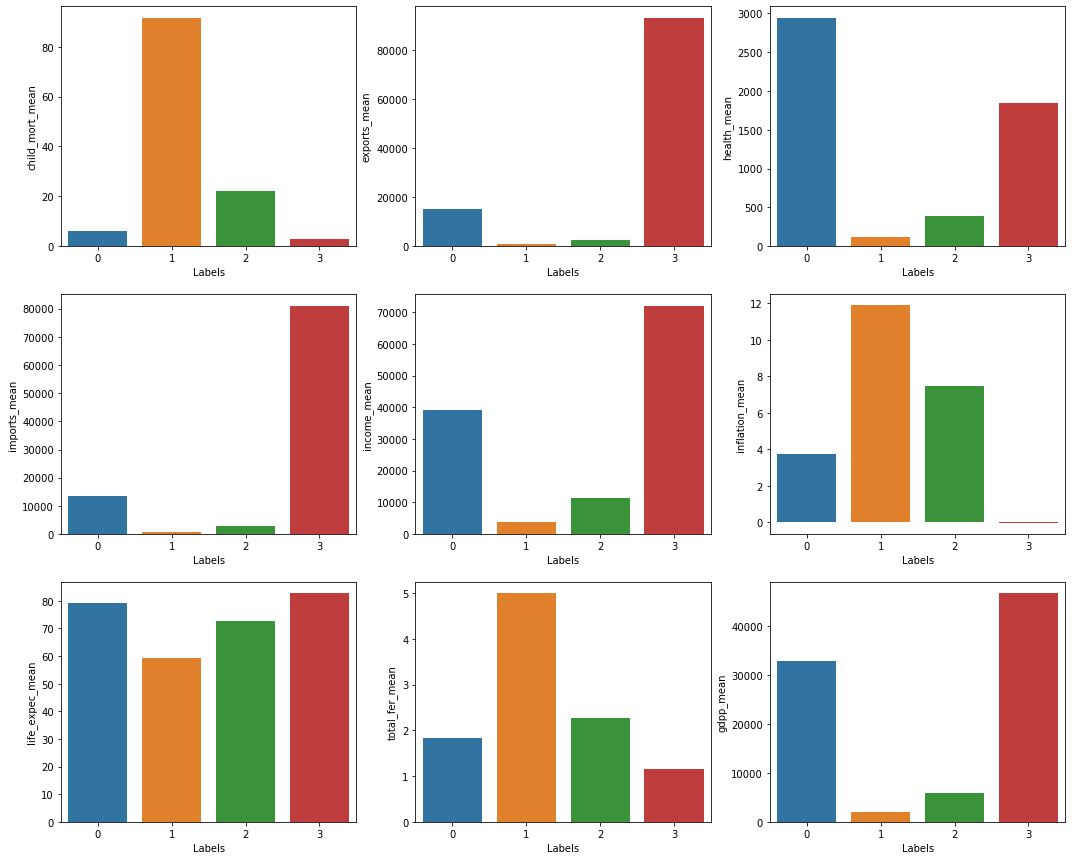

In [105]:
features = cluster_analysis_df.columns
fig = plt.figure(figsize=(18,15))
for plot, feature in enumerate(features[1:]):
    fig.add_subplot(3,3,plot+1)
    sns.barplot(cluster_analysis_df.Labels, cluster_analysis_df[feature])

From the above plot we can see that the criterias , namely, `gdpp, income and child mortality` are satified by cluster labeled 1 

In [106]:
#Binning the clusters to get the top 5 countries sorted in order exaplined above
clustered_kmeans=countries[countries_kmeans['Labels']==1]
clustered_kmeans.sort_values(['gdpp','income','child_mort','health','inflation','life_expec','total_fer','imports','exports'], 
                      ascending=[True,True,False,True,False,True,False,False,True]).head(10)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
26,Burundi,93.6,20.6052,26.7960,90.552,764,12.30,57.7,6.26,231
88,Liberia,89.3,62.4570,38.5860,302.802,700,5.47,60.8,5.02,327
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.80,57.5,6.54,334
112,Niger,123.0,77.2560,17.9568,170.868,814,2.55,58.8,7.49,348
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220,17.20,55.0,5.20,399
93,Madagascar,62.2,103.2500,15.5701,177.590,1390,8.79,60.8,4.60,413
106,Mozambique,101.0,131.9850,21.8299,193.578,918,7.64,54.5,5.56,419
31,Central African Republic,149.0,52.6280,17.7508,118.190,888,2.01,47.5,5.21,446
94,Malawi,90.5,104.6520,30.2481,160.191,1030,12.10,53.1,5.31,459
50,Eritrea,55.2,23.0878,12.8212,112.306,1420,11.60,61.7,4.61,482


### So from the above results and analysis, we can conclude that as per K- means clustering, the country which are direst need of aid are:
    1. Burundi
    2. Liberia
    3. Congo, Dem. Rep
    4. Niger
    5. Sierra Leone

##  Taking Hierarchical Clustering approach

#### Using the already cleaned and scaled data, done earlier in  kmeans analysis

In [107]:
country_norm.shape

(158, 9)

In [108]:
country_norm.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.234847,-0.510090,-0.563608,-0.530152,-0.856955,0.124994,-1.572901,1.838989,-0.738376
1,-0.582710,-0.396063,-0.391462,-0.321693,-0.308713,-0.336520,0.723646,-0.889676,-0.459367
2,-0.318473,-0.336697,-0.453862,-0.392076,-0.113006,0.745941,0.746497,-0.078274,-0.430180
3,1.946065,-0.285794,-0.518900,-0.378423,-0.574267,1.333323,-1.127302,2.061470,-0.503541
4,-0.738289,0.064875,-0.035126,0.301255,0.295540,-0.620888,0.780774,-0.575585,0.180376


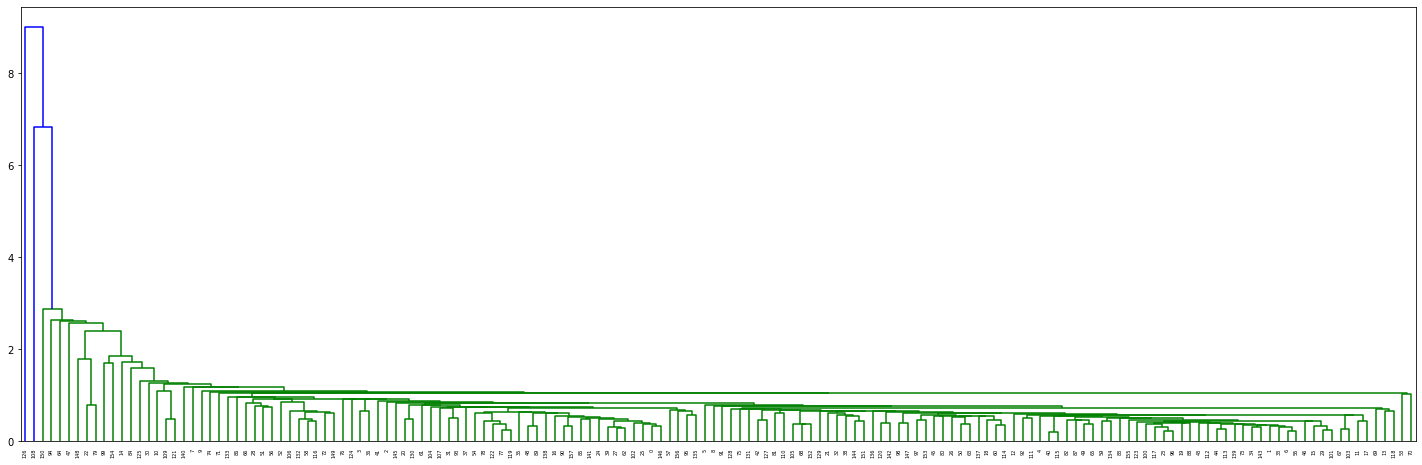

In [109]:
countries_hrcl  = country_norm.copy()
fig = plt.figure(figsize = (25,8))
mergings = linkage(countries_hrcl, method = "single", metric='euclidean')
dendrogram(mergings)
plt.show()

### By single method heirarchical clustering things are not clear, so let us go for complete heirarchical clustering method.

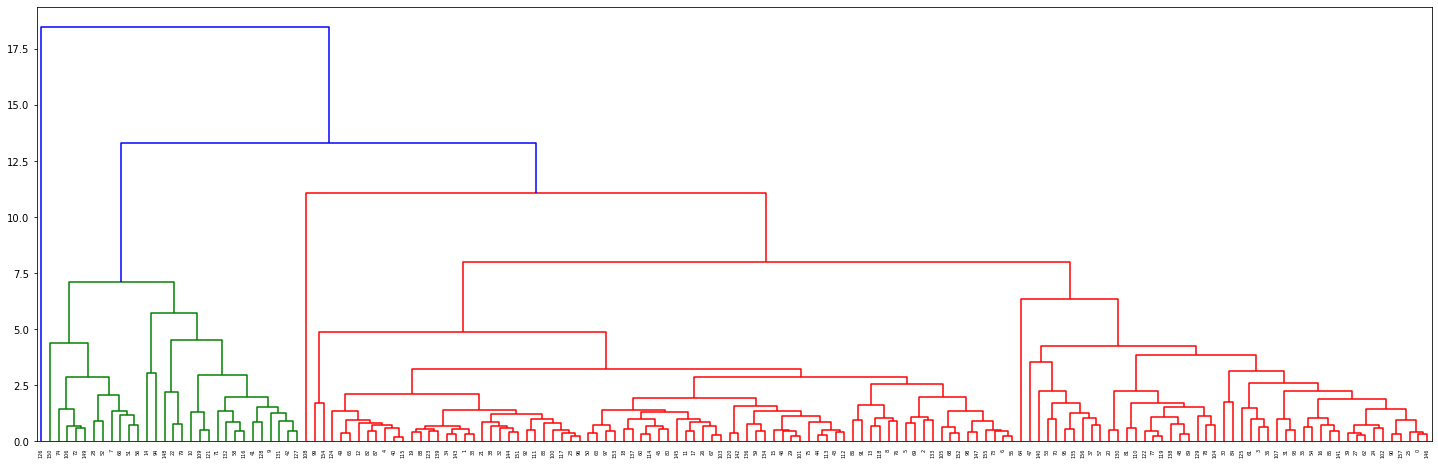

In [110]:
# HC with complete method
fig = plt.figure(figsize = (25, 8))
mergings = linkage(countries_hrcl, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

##### At 12.5 there are 3 clusters and at 10.0 there are 4 clusters
### Let us cut the dendrogram  such that there are  n_clusters = 4 


In [111]:
countries

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,1384.02,155.9250,1565.190,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,3847.50,662.8500,2376.000,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,943.20,89.6040,1050.620,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,393.00,67.8580,450.640,4480,23.60,67.5,4.67,1310


In [112]:
clusterCut = cut_tree(mergings, n_clusters = 4).reshape(-1,)
clusterCut

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0])

In [113]:
countries_hrcl_cluster = countries.copy()
countries_hrcl_cluster.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [114]:
countries_hrcl_cluster['Labels'] = pd.Series(clusterCut, index=countries.index)
countries_hrcl_cluster.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0


### Checking the number of countries assigned to each clusters

In [115]:
countries_hrcl_cluster['Labels'].value_counts()

0    127
1     29
3      1
2      1
Name: Labels, dtype: int64

The above numbers are quite different from the one which we got in kMeans method.
But that is understandable becuase the Hierarchical clustering method will form different clusters than the Kmeans one.

## Profiling the clusters based on  - [gdpp, child_mort and income] 

#### Bivariate analysis of clustered countries 

[Text(0, 0.5, 'Child Mortality Rate'), Text(0.5, 0, 'GDPP')]

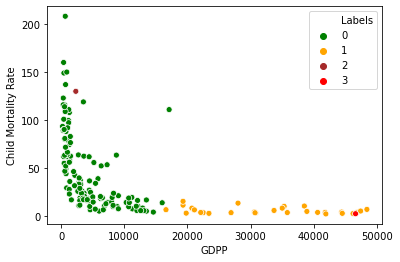

In [116]:
axes = sns.scatterplot(x='gdpp', y='child_mort', hue='Labels',legend='full',data=countries_hrcl_cluster, palette=['green','orange','brown','red'])
axes.set(xlabel = 'GDPP', ylabel= 'Child Mortality Rate')

[Text(0, 0.5, 'Income'), Text(0.5, 0, 'GDPP')]

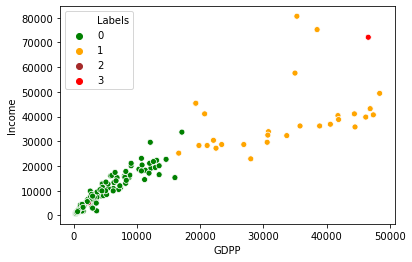

In [117]:
axes = sns.scatterplot(x='gdpp',y='income',hue='Labels',legend='full',data=countries_hrcl_cluster, palette=['green','orange','brown','red'])
axes.set(xlabel = 'GDPP', ylabel= 'Income')

[Text(0, 0.5, 'Income'), Text(0.5, 0, 'Child Mortality Rate')]

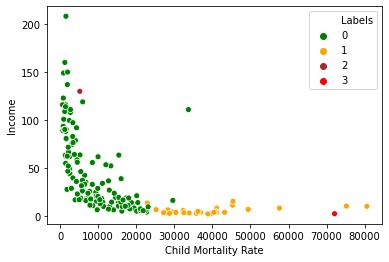

In [118]:
axes= sns.scatterplot(x='income',y='child_mort',hue='Labels',legend='full',data=countries_hrcl_cluster, palette=['green','orange','brown','red'])
axes.set(xlabel = 'Child Mortality Rate', ylabel= 'Income')

### From the above 3 scatterplots we can deduce the following insights about the clusters, specially about the clster labeled 0.

- In the gdpp vs child_mort plot, the child_mort is high when gdpp is low.
- In the gdpp vs income, when the gdpp is average the income is average.
- In the income vs child_mort, when income is high the child mortality is low and vice versa.

#### Taking the means of the features and analyzing the clusters further

In [119]:
child_mort_mean =pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).child_mort.mean())
exports_mean=pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).exports.mean())
health_mean =pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).health.mean())
imports_mean =pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).imports.mean())
income_mean =pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).income.mean())
inflat_mean =pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).inflation.mean())
life_expec_mean =pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).life_expec.mean())
total_fer_mean =pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).total_fer.mean())
gdpp_mean =pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).gdpp.mean())

In [120]:
hrcl_cluster_analysis_df = pd.concat([pd.Series([0,1,2,3]),child_mort_mean,exports_mean,health_mean,imports_mean,income_mean,inflat_mean,life_expec_mean,
                                 total_fer_mean,gdpp_mean], axis=1)

In [121]:
hrcl_cluster_analysis_df.columns = ["Labels","child_mort_mean","exports_mean","health_mean","imports_mean","income_mean","inflation_mean","life_expec_mean","total_fer_mean","gdpp_mean"]
hrcl_cluster_analysis_df

,Labels,child_mort_mean,exports_mean,health_mean,imports_mean,income_mean,inflation_mean,life_expec_mean,total_fer_mean,gdpp_mean
0,0,47.558268,1953.259508,285.526331,2069.379387,8663.094488,8.401528,67.816535,3.272835,4458.929134
1,1,6.148276,15076.862069,2941.186552,13582.134483,39024.137931,3.750069,79.268966,1.823448,32796.551724
2,2,130.000000,589.490000,118.131000,405.420000,5150.000000,104.000000,60.500000,5.840000,2330.000000
3,3,2.800000,93200.000000,1845.360000,81084.000000,72100.000000,-0.046000,82.700000,1.150000,46600.000000


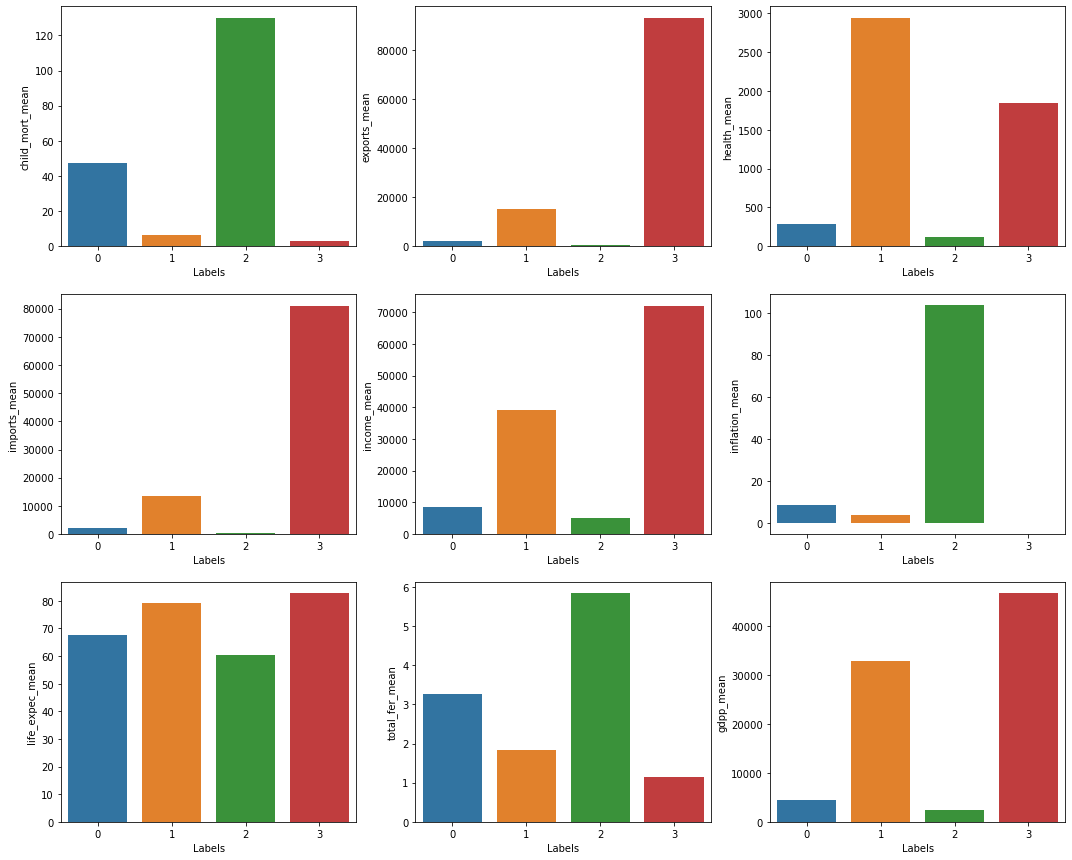

In [122]:
features = hrcl_cluster_analysis_df.columns
fig = plt.figure(figsize=(18,15))
for plot, feature in enumerate(features[1:]):
    fig.add_subplot(3,3,plot+1)
    sns.barplot(hrcl_cluster_analysis_df.Labels, hrcl_cluster_analysis_df[feature])

In [123]:
#Binning the clusters to get the top 5 countries sorted in order exaplined above
clustered_hrcl=countries[countries_hrcl_cluster['Labels']==0]
clustered_hrcl.sort_values(['gdpp','income','child_mort','health','inflation','life_expec','total_fer','imports','exports'], 
                      ascending=[True,True,False,True,False,True,False,False,True]).head(10)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
26,Burundi,93.6,20.6052,26.7960,90.552,764,12.30,57.7,6.26,231
88,Liberia,89.3,62.4570,38.5860,302.802,700,5.47,60.8,5.02,327
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.80,57.5,6.54,334
112,Niger,123.0,77.2560,17.9568,170.868,814,2.55,58.8,7.49,348
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220,17.20,55.0,5.20,399
93,Madagascar,62.2,103.2500,15.5701,177.590,1390,8.79,60.8,4.60,413
106,Mozambique,101.0,131.9850,21.8299,193.578,918,7.64,54.5,5.56,419
31,Central African Republic,149.0,52.6280,17.7508,118.190,888,2.01,47.5,5.21,446
94,Malawi,90.5,104.6520,30.2481,160.191,1030,12.10,53.1,5.31,459
50,Eritrea,55.2,23.0878,12.8212,112.306,1420,11.60,61.7,4.61,482


### So from the above results and analysis, we can conclude that as per Heirarchical clustering, the country which are direst need of aid are:
    1. Burundi
    2. Liberia
    3. Congo, Dem. Rep
    4. Niger
    5. Sierra Leone

### We got same countries by both K-means and Heirarchical Clustering techniques: 
##### Therefore following are the countries which are in direst need of aid by considering socio – economic factor into consideration:

    1. Burundi
    2. Liberia
    3. Congo, Dem. Rep.
    4. Niger
    5. Sierra Leone